# day7

> Day 7: No space left on device


This one is more complicated. Going to start at the _end_ of the description and work back. 

OK, I did, but as I worked back I kept adding things to the core classes, so it doesn't start as simple as I did.


In [ ]:
#| default_exp day6
NAME = "day7"

In [ ]:
#| hide
from nbdev.showdoc import *
%load_ext autoreload
%autoreload 2

---

# Define classes

## Directory

To begin, find all of the directories with a total size of at most 100000, then calculate the sum of their total sizes. In the example above, these directories are a and e; the sum of their total sizes is 95437 (94853 + 584). (As in this example, this process can count files more than once!)
```
- a (dir)
    - e (dir)
      - i (file, size=584)
    - f (file, size=29116)
    - g (file, size=2557)
    - h.lst (file, size=62596)
```

In [ ]:
#| exports
#| code-fold: true

from dataclasses import dataclass, field

@dataclass
class FileObj():
    """Base class for File & Directory. Has a name"""
    name: str
        
@dataclass
class File(FileObj):
    """Files have name and size"""
    size: int
        
    def __str__(me):
        return f"{me.name} (file, size={me.size})"

In [ ]:
#| test
i = File("i", 584)
f = File("f", 29116)
g = File("g", 2557)
h = File("h.lst", size=62596)
files = [i, f, g, h]

assert f"{i}" == "i (file, size=584)"

**Directories** compute their `.size` from their members. This is naturally recursive. 😊

Started really simple.  Added methods as I needed them later. Now has:

* `parent` so we can build `path` and know `depth`. Starts as `None`. 
   Gets assigned when our parent adds us.  Lets `__str__` to get indents right and avoids
   lets this structure be self-sufficient.
* Provides `[]` getting and setting, hiding internal dict `_files`. 
* Provides `subdirs` to get flat list of all subdirs under me. 
  Not sure this belongs _in_ the class.

:::{.comment-alert}
Initializing `_files: []` turns all `Directory` into Ender chests. Beware the _default-mutable_!
:::

:::{.comment-alert}
First solution failed in Part 1 (too low) because reused names tangled the tree.

Second solution failed in Part 1 (too high) because of a different way to tangle the tree.

:::

In [ ]:
#| exports
#| code-fold: true

@dataclass
class Directory(FileObj):
    """Directories have kids (files or dirs), and PARENT"""
    parent: FileObj=None
    _kids: dict[str: FileObj] = field(default_factory=dict)
    
    @property
    def size(me):
        return sum(f.size for f in me._kids.values())
    
    @property
    def path(me) -> str:
        """The path/to/me/"""
        try:
            return f"{me.parent.path}{me.name}/"
        except AttributeError:
            return f"{me.name}/"
        
    @property
    def depth(me):
        """How far down the tree am me?"""
        return me.path.count("/") - me.path.count("//") - 1
    
    @property
    def subdirs(me):
        """My kids what has kids"""
        return [x for x in me if isinstance(x, Directory)]
        
    def append(me, obj: FileObj) -> None:
        """Shortcut : obj already has name; use as key."""
        me[obj.name] = obj
        
    def __str__(me):
        """Indented tree below me."""
        indent = "  " * me.depth
        head = f"{me.name} (dir, size={me.size})"
        tail = f"\n".join(f"{indent} - {val}" for val in me)  # uses __iter__
        return f"{head}\n{tail}"
    
    def __iter__(me):
        """Return iterator of objects (not names!) in _kids."""
        return iter(me._kids.values())
    
    def __getitem__(me, name: str) -> FileObj:
        """Get member FileObj by name. Or die."""
        return me._kids[name]

    def __setitem__(me, name: str, arg: FileObj) -> None:
        """Add {arg.name: arg} to _files; if possible, set arg.parent->me."""
        me._kids[name] = arg
        if isinstance(arg, Directory):
            if arg.parent is not None:
                raise(ValueError, "We are stealing someone else's kid!")
            arg.parent = me


Test recursive size in 2-item case, and show `__str__`.

In [ ]:
#| test
e = Directory("e")
e.append(i)
assert e.size == i.size == 584
assert e["i"] == i
assert e.depth == 0
print(e)

e (dir, size=584)
 - i (file, size=584)


Ensure new Directory is independent!  (Catch default mutable error.)

In [ ]:
#| test
f = File("f", 29116)
root = Directory("/")
root.append(f)
assert root.size == f.size == 29116
assert root.depth == 0
print(root)

/ (dir, size=29116)
 - f (file, size=29116)


Test recursive sum and depth. Also show two-layer `__str__`.

In [ ]:
#| test
a = Directory("a")
root.append(a)
g, h = File("g", 2557), File("h.lst", size=62596)
f2 = File("f", 512) # <- Another file named f!
assert f2 is not f

for item in [e, f2, g, h, Directory("k")]:
    a.append(item)

print(root)
assert a.size == 66249
assert root.size == f.size + a.size
assert root.depth == 0
assert a.depth == 1
assert e.depth == 2
assert a["k"].depth == 2

/ (dir, size=95365)
 - f (file, size=29116)
 - a (dir, size=66249)
   - e (dir, size=584)
     - i (file, size=584)
   - f (file, size=512)
   - g (file, size=2557)
   - h.lst (file, size=62596)
   - k (dir, size=0)



Test the `subdirs` property at two depths. 

In [ ]:
#| test
assert [x.name for x in root.subdirs] == ['a']
assert [x.name for x in a.subdirs] == ['e', 'k']

## All subdirs

> This is basically a filtered depth-first traversal. 

This used to return dir objects. Changed to (name, size) tuples while trying to track down Part1 error that turned out to be something else entirely.

In [ ]:
#| exports
#| code-fold: true

def get_all_subdirs(start: Directory) -> list[Directory]:
    """Return flat list of (name, size) for _all_ dirs under `start` dir."""
    my_dirs = [(x.name, x.size) for x in start.subdirs]
    for _dir in start.subdirs:
        my_dirs.extend(get_all_subdirs(_dir))
    return my_dirs

In [ ]:
get_all_subdirs(root)

[('a', 66249), ('e', 584), ('k', 0)]

In [ ]:
#| test
assert [x[0] for x in get_all_subdirs(root)] == ['a', 'e', 'k']

OK, looks good!  Now need to read the data.

# Example

In [ ]:
#| exports

example = """
$ cd /
$ ls
dir a
14848514 b.txt
8504156 c.dat
dir d
$ cd a
$ ls
dir e
29116 f
2557 g
62596 h.lst
$ cd e
$ ls
584 i
$ cd ..
$ cd ..
$ cd d
$ ls
4060174 j
8033020 d.log
5626152 d.ext
7214296 k
""".strip().split("\n")

## Parse the dirs

In [ ]:
#| exports
#| code-fold: true

def get_dirs(commands: list[str]) -> Directory:
    """Create dir tree from '/'. Return all dirs"""
    root = Directory("/")
    dirstack = [root]

    for i, line in enumerate(commands):
        cur_dir = dirstack[-1]
        match line.split():
            case ("$", "ls"):
                continue
            case ("dir", dirname):
                try:
                    cur_dir[dirname]  # Should fail, unless twice ls same dir
                    print("*********** {dirname} already in {cur_dir.name}!")
                except KeyError:
                    cur_dir.append(Directory(dirname))
            case ("$", "cd", dirname):
                match dirname:
                    case "/":
                        dirstack = [root]
                    case "..":
                        dirstack.pop()
                    case _: 
                        dirstack.append(cur_dir[dirname])
                depth = len(dirstack) - 1
                print(f'{"❚" * depth}\tfrom cd {dirname}\t in line {i}')
            case (size, name):
                f = File(name, int(size))
                cur_dir.append(f)
            case _:
                raise ValueError(f"Unrecognized line: '{line}'")
    return root
            
dirs = get_dirs(example)

	from cd /	 in line 0
❚	from cd a	 in line 6
❚❚	from cd e	 in line 12
❚	from cd ..	 in line 15
	from cd ..	 in line 16
❚	from cd d	 in line 17


In [ ]:
#| test
print(dirs)
assert len(str(dirs).split("\n")) == 14

/ (dir, size=48381165)
 - a (dir, size=94853)
   - e (dir, size=584)
     - i (file, size=584)
   - f (file, size=29116)
   - g (file, size=2557)
   - h.lst (file, size=62596)
 - b.txt (file, size=14848514)
 - c.dat (file, size=8504156)
 - d (dir, size=24933642)
   - j (file, size=4060174)
   - d.log (file, size=8033020)
   - d.ext (file, size=5626152)
   - k (file, size=7214296)


We're told:
> The total size of directory e is 584 because it contains a single file i of size 584 and no other directories.
The directory a has total size 94853 because it contains files f (size 29116), g (size 2557), and h.lst (size 62596), plus file i indirectly (a contains e which contains i).
Directory d has total size 24933642.
As the outermost directory, / contains every file. Its total size is 48381165, the sum of the size of every file.

In [ ]:
#| test

assert dirs['a']['e'].size == 584
assert dirs['a'].size == 94853
assert dirs['d'].size == 24933642
assert dirs.size == 48381165

:::{.comment-note}
**ToDo** Special case `dirs["/"]` to get self?
:::

## With total size ≤ 100K

To begin, find all of the directories with a total size of at most 100000, then calculate the sum of their total sizes. In the example above, these directories are a and e; the sum of their total sizes is 95437 (94853 + 584). (As in this example, this process can count files more than once!)



In [ ]:
#| exports
#| code-fold: true

def sum_cutoff(start: Directory, cutoff=100_000) -> int:
    subdirs = get_all_subdirs(start)
    sizes = [x[1] for x in subdirs if x[1] < 100_000]
    return sum(x for x in sizes if x <= cutoff)

In [ ]:
#| test

assert sum_cutoff(dirs) == 95437

# Part 1

## Get the data


In [ ]:
input_name = f"data/{NAME}_input.txt"
with open(f"data/{NAME}_input.txt") as f:
    data = f.read()
data = data.strip().split("\n")

Examine the data - because it broke code that worked on the example.

In [ ]:
print(f"Data has {len(data)} commands. First few:")
print("\n".join(x for x in data[:10]))
lines_with_dir = [x for x in data if x.startswith('dir')]
print(f"There are {len(lines_with_dir)} lines with 'dir'.")

Data has 1014 commands. First few:
$ cd /
$ ls
dir blgtdv
dir dbrfcz
dir fvspj
dir hbjmndt
dir hzg
dir jpjgdm
dir mtd
dir pcpf
There are 182 lines with 'dir'.


Note that names get reused!

In [ ]:
fvspj = [row for row in data if "cd fvspj" in row]
fvspj2 = [row for row in data if "dir fvspj" in row]
print(f"There are {len(fvspj)} rows with 'cd fvspj'!")
print(f"There are {len(fvspj2)} rows with 'dir fvspj'!")

There are 13 rows with 'cd fvspj'!
There are 13 rows with 'dir fvspj'!


## Run

In [ ]:
#| output: false
part1_tree = get_dirs(data)

	from cd /	 in line 0
❚	from cd blgtdv	 in line 13
❚❚	from cd bjlcfcfq	 in line 23
❚❚❚	from cd fvspj	 in line 28
❚❚	from cd ..	 in line 32
❚❚❚	from cd pwcvj	 in line 33
❚❚❚❚	from cd bjp	 in line 46
❚❚❚❚❚	from cd scggvb	 in line 49
❚❚❚❚	from cd ..	 in line 52
❚❚❚	from cd ..	 in line 53
❚❚❚❚	from cd drsgv	 in line 54
❚❚❚	from cd ..	 in line 59
❚❚❚❚	from cd lpv	 in line 60
❚❚❚	from cd ..	 in line 64
❚❚❚❚	from cd mmtsh	 in line 65
❚❚❚	from cd ..	 in line 68
❚❚❚❚	from cd pwcvj	 in line 69
❚❚❚❚❚	from cd dnfnl	 in line 72
❚❚❚❚	from cd ..	 in line 75
❚❚❚	from cd ..	 in line 76
❚❚❚❚	from cd rdftpm	 in line 77
❚❚❚	from cd ..	 in line 81
❚❚❚❚	from cd rzhq	 in line 82
❚❚❚❚❚	from cd wcnm	 in line 85
❚❚❚❚	from cd ..	 in line 88
❚❚❚	from cd ..	 in line 89
❚❚	from cd ..	 in line 90
❚❚❚	from cd tvhrzql	 in line 91
❚❚	from cd ..	 in line 94
❚	from cd ..	 in line 95
❚❚	from cd gzzz	 in line 96
❚	from cd ..	 in line 99
❚❚	from cd nbdzs	 in line 100
❚	from cd ..	 in line 104
❚❚	from cd vvmcfptr	 in line 10

Screenshot from output:

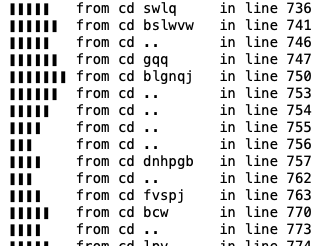

In [ ]:
#| output: false
print(part1_tree)

/ (dir, size=47870454)
 - blgtdv (dir, size=4564224)
   - bjlcfcfq (dir, size=3239931)
     - fvspj (dir, size=327970)
       - cqwb.qzt (file, size=315202)
       - lmdtnsmr (file, size=12768)
     - pwcvj (dir, size=2589622)
       - bjp (dir, size=29012)
         - scggvb (dir, size=29012)
           - lmdtnsmr (file, size=29012)
       - btj.sdn (file, size=138548)
       - cllbb (file, size=140056)
       - drsgv (dir, size=549918)
         - btj.sdn (file, size=41717)
         - jctnszj.nnc (file, size=203587)
         - rdvjhjjr.bbt (file, size=304614)
       - fvspj (file, size=311875)
       - lpv (dir, size=596985)
         - nlrbdjhf (file, size=292112)
         - rdvjhjjr.bbt (file, size=304873)
       - mmtsh (dir, size=12318)
         - fbvvrvc.shb (file, size=12318)
       - pwcvj (dir, size=191701)
         - dnfnl (dir, size=191701)
           - qfswvhj.wgs (file, size=191701)
       - qrd.ngg (file, size=252680)
       - rdftpm (dir, size=217233)
         - fvwcjbsl.t

Screenshot from output:

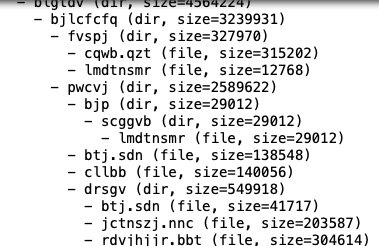

In [ ]:
part1_subdirs = get_all_subdirs(part1_tree)
data_dirs = [x for x in data if x.startswith("$ cd") and not x.endswith("..")]
n_getall = len(part1_subdirs)
f"{n_getall} from get_all_subdirs; {len(data)} commands, of which {len(data_dirs)} cd to dir."

'182 from get_all_subdirs; 1014 commands, of which 183 cd to dir.'

In [ ]:
assert n_getall <= len(data_dirs)
assert len(data_dirs) < len(data)

**Answer!**

In [ ]:
sum_cutoff(part1_tree)


1667443

* Guess 1: 66833 -> **Too low**
* Guess 2: 214,201,382 -> **Too high** Oh gosh yes, it's larger than size of /!

**D'oh!**  While some cleanups of the classes and functions no doubt helped, the core problem was:
```
sum_cutoff(root)
```
Rather than 
```
sum_cutoff(part1_tree)
```
Copy/paste error: "root" was the _example_.  

Correct answer for Part1: 1,667,443

# Part 2

The total disk space on the file system is 70_000_000.

To run the update, you need unused space of at least 30_000_000. 

Find the **smallest** directory that, if deleted, would free up enough space on the filesystem to run the update. **What is the total size of that directory**?

In [ ]:
disk_space = 70_000_000
required = 30_000_000
used = part1_tree.size
free = disk_space - used
needed = required - free
print(f"{needed:,} needed")

7,870,454 needed


In [ ]:
candidates = [x for x in part1_subdirs if x[1] > needed]
candidates

[('jpjgdm', 30324496),
 ('tgrplmn', 13900160),
 ('lpv', 12331326),
 ('bjlcfcfq', 8998590)]

In [ ]:
min(candidates, key=lambda x: x[1])

('bjlcfcfq', 8998590)

Well that was straightforward once I had Part 1!

----
Footer: nbdev magic

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()